In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/last-c207-txt/C207 (1).csv


In [2]:
import pandas as pd

file_path = '/kaggle/input/last-c207-txt/C207 (1).csv'

df = pd.read_csv(file_path)

df.columns = ["Customer", "X", "Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]

df.head(20)


,Customer,X,Y,Demand,ReadyTime,DueDate,ServiceTime
0,1,40,50,0,0,3390,0
1,2,52,75,10,302,479,90
2,3,45,70,30,157,428,90
3,4,62,69,10,1138,1355,90
4,5,60,66,10,1247,1434,90
5,6,42,65,10,15,208,90
6,7,16,42,20,209,944,90
7,8,58,70,20,1059,1246,90
8,9,34,60,20,2035,3288,90
9,10,28,70,10,2090,3271,90


 Running Black-Winged Kite Algorithm (BWKA) Only 
Iteration 1: Best Cost = 3633.13
Iteration 20: Best Cost = 3633.13
Iteration 40: Best Cost = 3633.13
Iteration 60: Best Cost = 3633.13
Iteration 80: Best Cost = 3633.13
Iteration 100: Best Cost = 3633.13
Iteration 120: Best Cost = 3633.13
Iteration 140: Best Cost = 3633.13
Iteration 160: Best Cost = 3633.13
Iteration 180: Best Cost = 3633.13
Iteration 200: Best Cost = 3633.13


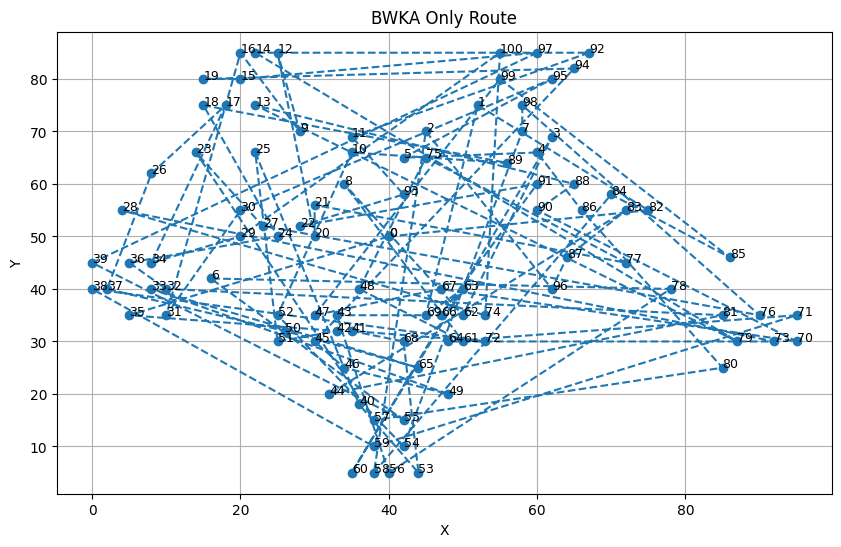


 Running Nearest Neighbor + BWKA 
Iteration 1: Best Cost = 703.97
Iteration 20: Best Cost = 703.97
Iteration 40: Best Cost = 703.97
Iteration 60: Best Cost = 703.97
Iteration 80: Best Cost = 703.97
Iteration 100: Best Cost = 703.97
Iteration 120: Best Cost = 703.97
Iteration 140: Best Cost = 703.97
Iteration 160: Best Cost = 703.97
Iteration 180: Best Cost = 703.97
Iteration 200: Best Cost = 703.97


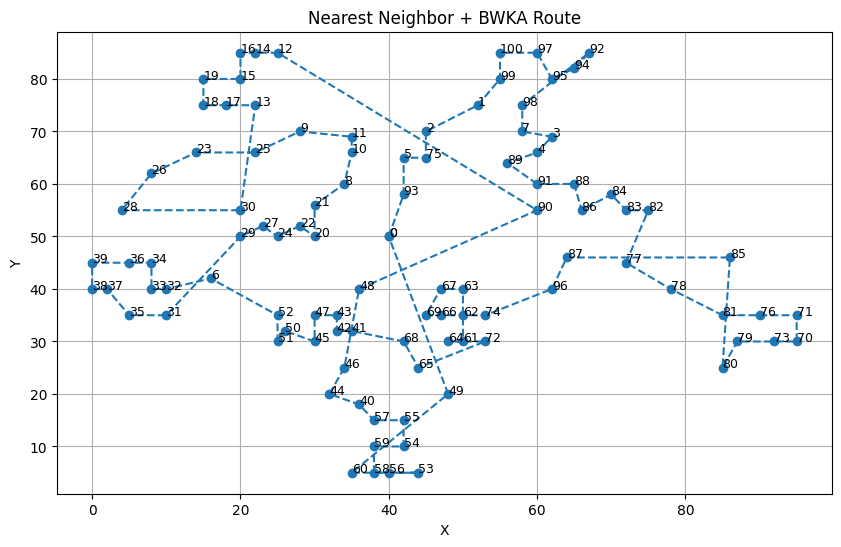



 Final Comparison:
Method               |       Cost
--------------------------------
BWKA Only            |    3633.13
NN + BWKA            |     703.97


In [3]:
# Black winged Kite + Nearest Neighbor 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/kaggle/input/last-c207-txt/C207 (1).csv'
df = pd.read_csv(file_path)

locations = df[["XCOORD.", "YCOORD."]].values
demands = df["DEMAND"].values
ready_times = df["READY TIME"].values
due_dates = df["DUE DATE"].values
service_times = df["SERVICE TIME"].values

vehicle_capacity = 700
num_customers = len(df)
depot = 0

def compute_distance_matrix(locations):
    n = len(locations)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i][j] = np.linalg.norm(locations[i] - locations[j])
    return dist_matrix

distance_matrix = compute_distance_matrix(locations)

def is_valid_route(route, dist_matrix, demands, ready_times, due_dates, service_times):
    current_time = 0
    load = vehicle_capacity
    prev = 0  

    for node in route:
        distance = dist_matrix[prev][node]
        arrival_time = current_time + distance

        if arrival_time < ready_times[node]:
            current_time = ready_times[node]
        elif arrival_time > due_dates[node]:
            return False 

        current_time += service_times[node]
        load -= demands[node]
        if load < 0:
            return False  

        prev = node
        current_time += dist_matrix[prev][0]  

    return True

def nearest_neighbor(start, dist_matrix):
    n = len(dist_matrix)
    visited = [False] * n
    route = [start]
    visited[start] = True
    current = start

    while len(route) < n:
        nearest = None
        nearest_dist = float('inf')
        for i in range(n):
            if not visited[i] and dist_matrix[current][i] < nearest_dist:
                nearest = i
                nearest_dist = dist_matrix[current][i]
        route.append(nearest)
        visited[nearest] = True
        current = nearest
    return route

def evaluate_solution(route, dist_matrix):
    total_distance = 0
    prev = 0
    for node in route:
        total_distance += dist_matrix[prev][node]
        prev = node
    total_distance += dist_matrix[prev][0]
    return total_distance

def bwka(dist_matrix, population_size=5, iterations=2000, use_nn=False):
    n = len(dist_matrix)

    def initialize_population():
        if use_nn:
            base_route = nearest_neighbor(0, dist_matrix)[1:]
            population = [base_route.copy() for _ in range(population_size)]
            for i in range(1, population_size):
                route = base_route.copy()
                i1, i2 = np.random.choice(len(route), 2, replace=False)
                route[i1], route[i2] = route[i2], route[i1]
                population[i] = route
            return population
        else:
            return [list(np.random.permutation(range(1, n))) for _ in range(population_size)]

    def perturb(route):
        new_route = route.copy()
        if np.random.rand() < 0.5:
            i, j = sorted(np.random.choice(len(route), 2, replace=False))
            new_route[i:j] = reversed(new_route[i:j])
        else:
            i, j = np.random.choice(len(route), 2, replace=False)
            new_route[i], new_route[j] = new_route[j], new_route[i]
        return new_route

    population = initialize_population()
    fitnesses = [evaluate_solution(r, dist_matrix) for r in population]
    best_idx = np.argmin(fitnesses)
    global_best = population[best_idx]
    global_best_cost = fitnesses[best_idx]

    for it in range(iterations):
        new_population = []
        for i in range(population_size):
            candidate = perturb(population[i])
            if is_valid_route(candidate, dist_matrix, demands, ready_times, due_dates, service_times):
                candidate_cost = evaluate_solution(candidate, dist_matrix)
                curr_cost = evaluate_solution(population[i], dist_matrix)
                if candidate_cost < curr_cost:
                    new_population.append(candidate)
                else:
                    new_population.append(population[i])
                if candidate_cost < global_best_cost:
                    global_best = candidate
                    global_best_cost = candidate_cost
            else:
                new_population.append(population[i])  
        population = new_population
        if (it+1) % 20 == 0 or it == 0:
            print(f"Iteration {it+1}: Best Cost = {global_best_cost:.2f}")
    return global_best, global_best_cost

def plot_route(route, locations, title="Best Route"):
    ordered = [0] + list(route) + [0]
    xs = [locations[i][0] for i in ordered]
    ys = [locations[i][1] for i in ordered]
    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o', linestyle='--')
    for idx in ordered:
        plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=9)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    print(" Running Black-Winged Kite Algorithm (BWKA) Only ")
    best_route_bwka, best_cost_bwka = bwka(distance_matrix, population_size=20, iterations=200, use_nn=False)
    plot_route(best_route_bwka, locations, title="BWKA Only Route")

    print("\n Running Nearest Neighbor + BWKA ")
    best_route_nn_bwka, best_cost_nn_bwka = bwka(distance_matrix, population_size=20, iterations=200, use_nn=True)
    plot_route(best_route_nn_bwka, locations, title="Nearest Neighbor + BWKA Route")

    print("\n\n Final Comparison:")
    print(f"{'Method':<20} | {'Cost':>10}")
    print("-" * 32)
    print(f"{'BWKA Only':<20} | {best_cost_bwka:>10.2f}")
    print(f"{'NN + BWKA':<20} | {best_cost_nn_bwka:>10.2f}")

Iteration 1, Best Cost: 4356.41
Iteration 2, Best Cost: 4348.27
Iteration 3, Best Cost: 4318.08
Iteration 4, Best Cost: 4318.08
Iteration 5, Best Cost: 4318.08
Iteration 6, Best Cost: 4318.08
Iteration 7, Best Cost: 4318.08
Iteration 8, Best Cost: 4318.08
Iteration 9, Best Cost: 4318.08
Iteration 10, Best Cost: 4318.08
Iteration 11, Best Cost: 4318.08
Iteration 12, Best Cost: 4318.08
Iteration 13, Best Cost: 4318.08
Iteration 14, Best Cost: 4318.08
Iteration 15, Best Cost: 4318.08
Iteration 16, Best Cost: 4318.08
Iteration 17, Best Cost: 4318.08
Iteration 18, Best Cost: 4318.08
Iteration 19, Best Cost: 4318.08
Iteration 20, Best Cost: 4318.08
Iteration 21, Best Cost: 4318.08
Iteration 22, Best Cost: 4318.08
Iteration 23, Best Cost: 4318.08
Iteration 24, Best Cost: 4318.08
Iteration 25, Best Cost: 4318.08
Iteration 26, Best Cost: 4318.08
Iteration 27, Best Cost: 4318.08
Iteration 28, Best Cost: 4318.08
Iteration 29, Best Cost: 4318.08
Iteration 30, Best Cost: 4318.08
Iteration 31, Best 

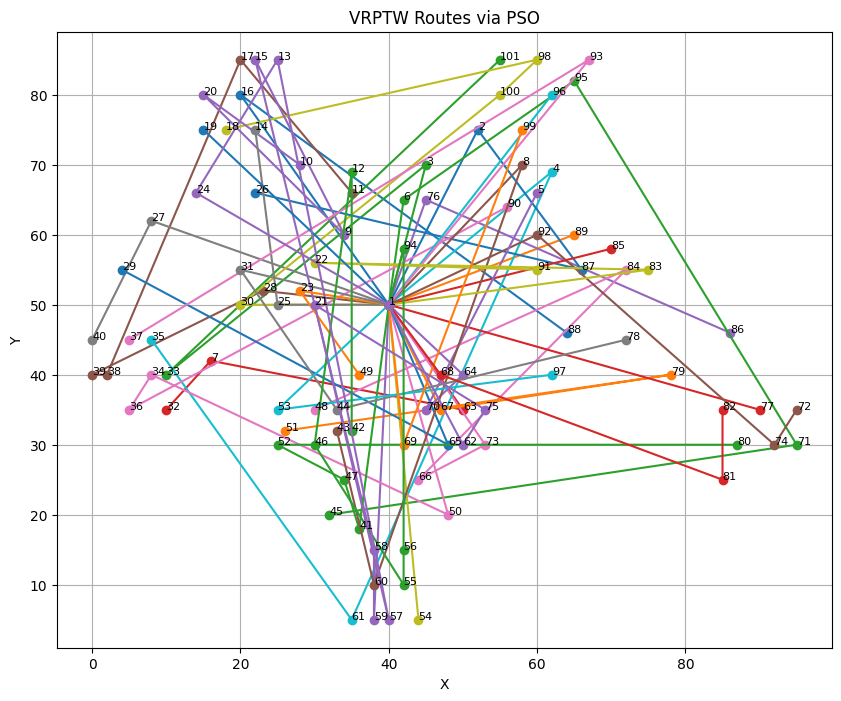

In [4]:
# Particle Swarm 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import random

file_path = '/kaggle/input/last-c207-txt/C207 (1).csv'
df = pd.read_csv(file_path)
def load_vrptw_data(path):
    df = pd.read_csv(path)
    df.columns = [col.strip().upper() for col in df.columns]
    df.rename(columns={
        'CUST NO.': 'id',
        'XCOORD.': 'x',
        'YCOORD.': 'y',
        'DEMAND': 'demand',
        'READY TIME': 'ready_time',
        'DUE DATE': 'due_date',
        'SERVICE TIME': 'service_time',
        'SERVICE TI': 'service_time'
    }, inplace=True)
    return df.to_dict('records')

def euclidean_distance(x1, y1, x2, y2):
    return sqrt((x2 - x1)**2 + (y2 - y1)**2)

def evaluate_solution(route, customers, vehicle_capacity=200):
    depot = customers[0]
    total_distance = 0
    load = 0
    time = 0
    penalty = 0
    current = depot
    routes = [[0]]

    for idx in route:
        cust = customers[idx]
        travel_time = euclidean_distance(current['x'], current['y'], cust['x'], cust['y'])
        arrival_time = time + travel_time

        if load + cust['demand'] > vehicle_capacity or arrival_time > cust['due_date']:
            total_distance += euclidean_distance(current['x'], current['y'], depot['x'], depot['y'])
            current = depot
            load = 0
            time = 0
            routes.append([0])
            travel_time = euclidean_distance(current['x'], current['y'], cust['x'], cust['y'])
            arrival_time = travel_time

        time = max(arrival_time, cust['ready_time']) + cust['service_time']
        load += cust['demand']
        total_distance += travel_time
        current = cust
        routes[-1].append(idx)

    total_distance += euclidean_distance(current['x'], current['y'], depot['x'], depot['y'])
    routes[-1].append(0)
    return total_distance + penalty, routes

def initialize_particles(n_pop, n_customers):
    particles = []
    for _ in range(n_pop):
        position = list(np.random.permutation(range(1, n_customers)))
        velocity = []
        particles.append({'position': position, 'velocity': velocity, 'best_pos': position, 'best_cost': float('inf')})
    return particles

def pso_vrptw(customers, n_pop=30, max_iter=100, c1=1.5, c2=1.5, w=0.7, wdamp=0.99):
    n_customers = len(customers)
    particles = initialize_particles(n_pop, n_customers)
    gbest = {'position': None, 'cost': float('inf')}

    for p in particles:
        cost, _ = evaluate_solution(p['position'], customers)
        p['best_pos'] = p['position'][:]
        p['best_cost'] = cost
        if cost < gbest['cost']:
            gbest['position'] = p['position'][:]
            gbest['cost'] = cost

    for it in range(max_iter):
        for p in particles:
            new_pos = p['position'][:]
            if random.random() < 0.3:
                i, j = random.sample(range(len(new_pos)), 2)
                new_pos[i], new_pos[j] = new_pos[j], new_pos[i]

            cost, _ = evaluate_solution(new_pos, customers)
            if cost < p['best_cost']:
                p['best_pos'] = new_pos[:]
                p['best_cost'] = cost
                if cost < gbest['cost']:
                    gbest['position'] = new_pos[:]
                    gbest['cost'] = cost

        w *= wdamp
        print(f"Iteration {it+1}, Best Cost: {gbest['cost']:.2f}")

    return gbest

def plot_routes(customers, routes):
    plt.figure(figsize=(10, 8))
    for route in routes:
        x = [customers[i]['x'] for i in route]
        y = [customers[i]['y'] for i in route]
        plt.plot(x, y, marker='o')
    for cust in customers:
        plt.text(cust['x'], cust['y'], str(cust['id']), fontsize=8)
    plt.title("VRPTW Routes via PSO")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    dataset_path = "/kaggle/input/last-c207-txt/C207 (1).csv"  
    customers = load_vrptw_data(dataset_path)
    best = pso_vrptw(customers, n_pop=50, max_iter=200)
    print("\n Best Route Found with Cost:", best['cost'])
    _, routes = evaluate_solution(best['position'], customers)
    plot_routes(customers, routes)

Iteration 0 - Best Cost: 4468.231574083593
Iteration 1 - Best Cost: 3714.3392769671823
Iteration 2 - Best Cost: 3570.0513554509535
Iteration 3 - Best Cost: 3604.1700562671363
Iteration 4 - Best Cost: 3658.5399430706534
Iteration 5 - Best Cost: 3508.8988854549
Iteration 6 - Best Cost: 3484.0260664819107
Iteration 7 - Best Cost: 3405.6511556412006
Iteration 8 - Best Cost: 3635.198264273221
Iteration 9 - Best Cost: 3504.6045495114167
Iteration 10 - Best Cost: 3765.185904590467
Iteration 11 - Best Cost: 3547.9870929045605
Iteration 12 - Best Cost: 3750.5418102097387
Iteration 13 - Best Cost: 3655.6918608836163
Iteration 14 - Best Cost: 3683.4028774343737
Iteration 15 - Best Cost: 3537.363346699205
Iteration 16 - Best Cost: 3717.8957098316937
Iteration 17 - Best Cost: 3726.761221562686
Iteration 18 - Best Cost: 3605.471115735206
Iteration 19 - Best Cost: 3700.2478275236763
Iteration 20 - Best Cost: 3542.391673386982
Iteration 21 - Best Cost: 3545.289342589672
Iteration 22 - Best Cost: 3638.

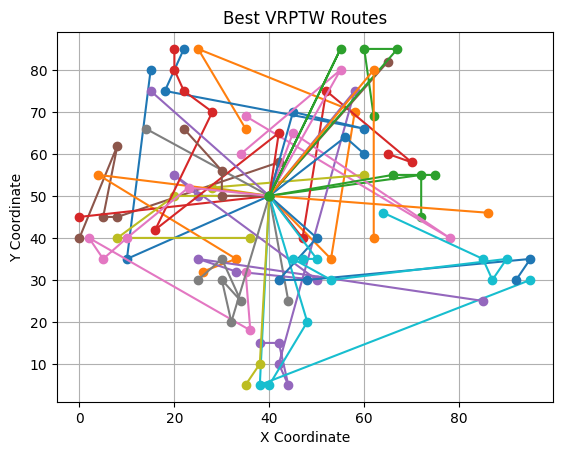

In [5]:
#Gray wolf algorithm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


def load_vrptw_data(path='/kaggle/input/last-c207-txt/C207 (1).csv'):
    df = pd.read_csv(path)

    df.columns = [col.strip().upper() for col in df.columns]
    rename_map = {
        'CUST NO.': 'id',
        'XCOORD.': 'x',
        'YCOORD.': 'y',
        'DEMAND': 'demand',
        'READY TIME': 'ready_time',
        'DUE DATE': 'due_date',
        'SERVICE TIME': 'service_time',
        'SERVICE TI': 'service_time'
    }
    df.rename(columns=rename_map, inplace=True)

    return df.to_dict('records')


def euclidean_distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)


def evaluate_solution(solution, customers, vehicle_capacity=700):
    total_distance = 0
    time = 0
    load = 0
    current_customer = customers[0]  
    route = [[0]]  

    for idx in solution:
        customer = customers[idx]
        travel_time = euclidean_distance(current_customer['x'], current_customer['y'], customer['x'], customer['y'])
        arrival_time = time + travel_time

        if (load + customer['demand'] > vehicle_capacity or arrival_time > customer['due_date']):
            total_distance += euclidean_distance(current_customer['x'], current_customer['y'],
                                                 customers[0]['x'], customers[0]['y'])
            time = 0
            load = 0
            current_customer = customers[0]
            route.append([0])
            travel_time = euclidean_distance(current_customer['x'], current_customer['y'], customer['x'], customer['y'])
            arrival_time = time + travel_time

        time = max(arrival_time, customer['ready_time']) + customer['service_time']
        load += customer['demand']
        total_distance += travel_time
        route[-1].append(idx)
        current_customer = customer

    total_distance += euclidean_distance(current_customer['x'], current_customer['y'], customers[0]['x'], customers[0]['y'])
    route[-1].append(0)
    return total_distance, route


def initial_position_vrptw(pack_size, customer_size, target_function, customers):
    position = []
    for _ in range(pack_size):
        sol = list(np.random.permutation(range(1, customer_size)))
        cost, _ = target_function(sol, customers)
        position.append(sol + [cost])
    return np.array(position, dtype=object)


def update_position_vrptw(position, alpha, beta, delta, a_linear_component, target_function, customers):
    updated_position = []
    n = len(alpha)

    for pos in position:
        wolf = pos[:-1]
        new_wolf = wolf.copy()

        for i in range(n):
            r1, r2 = np.random.rand(), np.random.rand()
            A1 = 2 * a_linear_component * r1 - a_linear_component
            C1 = 2 * r2
            D_alpha = abs(C1 * alpha[i] - wolf[i])
            x1 = int(abs(alpha[i] - A1 * D_alpha)) % n + 1

            r1, r2 = np.random.rand(), np.random.rand()
            A2 = 2 * a_linear_component * r1 - a_linear_component
            C2 = 2 * r2
            D_beta = abs(C2 * beta[i] - wolf[i])
            x2 = int(abs(beta[i] - A2 * D_beta)) % n + 1

            r1, r2 = np.random.rand(), np.random.rand()
            A3 = 2 * a_linear_component * r1 - a_linear_component
            C3 = 2 * r2
            D_delta = abs(C3 * delta[i] - wolf[i])
            x3 = int(abs(delta[i] - A3 * D_delta)) % n + 1

            new_wolf[i] = [x1, x2, x3][np.random.randint(0, 3)]

        seen = set()
        new_solution = []
        for val in new_wolf:
            if val not in seen and 1 <= val < len(customers):
                new_solution.append(val)
                seen.add(val)

        for i in range(1, len(customers)):
            if i not in seen:
                new_solution.append(i)

        cost, _ = target_function(new_solution, customers)
        updated_position.append(new_solution + [cost])

    return np.array(updated_position, dtype=object)


def grey_wolf_optimizer_vrptw(pack_size, customers, iterations, target_function):
    customer_size = len(customers)
    position = initial_position_vrptw(pack_size, customer_size, target_function, customers)
    alpha = min(position, key=lambda x: x[-1])
    beta = sorted(position, key=lambda x: x[-1])[1]
    delta = sorted(position, key=lambda x: x[-1])[2]

    for t in range(iterations):
        print(f"Iteration {t} - Best Cost: {alpha[-1]}")
        a = 2 - t * (2 / iterations)
        position = update_position_vrptw(position, alpha[:-1], beta[:-1], delta[:-1], a, target_function, customers)
        sorted_pack = sorted(position, key=lambda x: x[-1])
        alpha, beta, delta = sorted_pack[0], sorted_pack[1], sorted_pack[2]

    return alpha


def plot_routes(routes, customers):
    for route in routes:
        x = [customers[i]['x'] for i in route]
        y = [customers[i]['y'] for i in route]
        plt.plot(x, y, marker='o')
    plt.title('Best VRPTW Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    customers = load_vrptw_data('/kaggle/input/last-c207-txt/C207 (1).csv')
    best_solution = grey_wolf_optimizer_vrptw(
        pack_size=30,
        customers=customers,
        iterations=100,
        target_function=evaluate_solution
    )

    print("\nBest Routes:", best_solution[:-1])
    print("\nLowest cost(dist):", best_solution[-1])
    _, routes = evaluate_solution(best_solution[:-1], customers)
    plot_routes(routes, customers)


 Simulated Annealing 
Route: [28, 24, 41, 54, 73, 84, 44, 90, 50, 88, 11, 47, 32, 35, 52, 23, 42, 10, 30, 34, 9, 2, 96, 45, 21, 22, 1, 78, 66, 80, 70, 43, 46, 4, 79, 85, 59, 37, 93, 29, 6, 57, 36, 19, 74, 77, 68, 5, 56, 87, 92, 7, 91, 49, 72, 61, 64, 38, 31, 55, 65, 100, 97, 60, 76, 71, 8, 39, 12, 13, 20, 53, 58, 18, 26, 25, 48, 16, 82, 17, 67, 81, 83, 69, 51, 33, 98, 86, 89, 95, 40, 63, 14, 75, 27, 99, 94, 3, 15, 62]
Total Distance: 3347.99


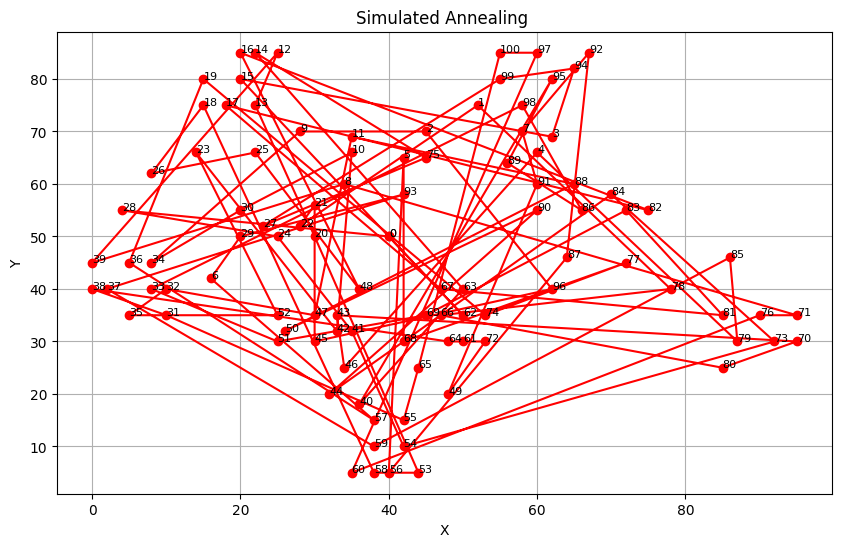

In [6]:
#Simulated Annealing 
import numpy as np
import pandas as pd

file_path = '/kaggle/input/last-c207-txt/C207 (1).csv'  

with open(file_path, 'r') as file:
    lines = file.readlines()
  
df.columns = ["Customer", "X", "Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
locations = df[["X", "Y"]].values

def compute_distance_matrix(locs):
    n = len(locs)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i][j] = np.linalg.norm(locs[i] - locs[j])
    return dist

distance_matrix = compute_distance_matrix(locations)

def evaluate_route(route, distance_matrix):
    cost = 0
    prev = 0
    for node in route:
        cost += distance_matrix[prev][node]
        prev = node
    cost += distance_matrix[prev][0]
    return cost

def generate_random_solution(num_customers):
    return list(np.random.permutation(range(1, num_customers)))  

def perturb(route):
    new_route = route.copy()
    i, j = np.random.choice(len(route), 2, replace=False)
    new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def bad_simulated_annealing(distance_matrix, num_customers, initial_temp=1000, cooling_rate=0.90, iterations=100):
    current_solution = generate_random_solution(num_customers)
    best_solution = current_solution.copy()
    current_cost = evaluate_route(current_solution, distance_matrix)
    best_cost = current_cost
    temp = initial_temp

    for _ in range(iterations):
        new_solution = perturb(current_solution)
        new_cost = evaluate_route(new_solution, distance_matrix)
        if new_cost < current_cost or np.random.rand() < np.exp((current_cost - new_cost) / temp):
            current_solution = new_solution
            current_cost = new_cost
            if new_cost < best_cost:
                best_solution = new_solution
                best_cost = new_cost
        temp *= cooling_rate 
    return best_solution, best_cost

num_customers = len(df)
bad_route, bad_cost = bad_simulated_annealing(distance_matrix, num_customers)

print(" Simulated Annealing ")
print("Route:", bad_route)
print("Total Distance:", round(bad_cost, 2))

import matplotlib.pyplot as plt

def plot_route(route, locations, title="Simulated Annealing "):
    ordered = [0] + route + [0] 
    xs = [locations[i][0] for i in ordered]
    ys = [locations[i][1] for i in ordered]

    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o', linestyle='-', color='red')
    for idx in ordered:
        plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=8)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

plot_route(bad_route, locations)
